In [2]:
from rdkit import Chem
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import warnings
import seaborn as sns
import umap
warnings.filterwarnings('ignore')

TCfile_path = './data/1-Cal_300_all.csv'
Featurefile_path = './data/6-RD_300_all.csv'
TCdata = pd.read_csv(TCfile_path, index_col='SAMindex')
Featuredata = pd.read_csv(Featurefile_path, index_col='SAMindex')
data = TCdata.merge(Featuredata, left_index=True, right_index=True, how='inner')

X = data.iloc[:, 2:]
y = data['TC_mean']

In [3]:
def classify_by_functional_group(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 'Invalid SMILES'
    
    functional_groups = {
        '1Alcohol': '[OH]', # 醇基
        '2Carboxylic_Acid': '[C](=O)[OH]', # 羟基
        '3Ester': '[C](=O)[O][!H]',  # 酯基
        '4Aldehyde': '[C](=O)[H]', # 醛基
        '5Ketone': '[C](=O)[C]', # 酮基
        '6Amine': '[N]', # 胺基
        '7Amide': '[C](=O)[N]', #酰胺基
        '8Ether': 'C-O-C', # 醚基
        '9Aromatic_Hydrocarbon': 'c1ccccc1', # 芳香烃
        '10Cyclohexane': 'C1CCCCC1',#环烷烃
    }
    
    categories = []
    for group, smarts in functional_groups.items():
        if mol.HasSubstructMatch(Chem.MolFromSmarts(smarts)):
            categories.append(group)
    
    return ', '.join(categories) if categories else '11Other'

In [4]:
results = []
for index, smiles in zip(data.index, data['EGsmlie2D']):
    category = classify_by_functional_group(smiles)
    lencategory = len(category.split(','))
    results.append({'SAMindex': index, 'EGsmlie2D': smiles, 'Category': category, 'kinds':lencategory})

df = pd.DataFrame(results)
df.set_index('SAMindex', inplace=True)
df.to_csv('classified_smiles.csv', index=True)

In [5]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=37)
embedding = reducer.fit_transform(X)

df['UMAP1'] = embedding[:, 0]
df['UMAP2'] = embedding[:, 1]
df['TC_mean'] = y

In [6]:
df

,EGsmlie2D,Category,kinds,UMAP1,UMAP2,TC_mean
SAMindex,,,,,,
SAM001,Cc1ccc(Nc2ccccc2)cc1C,"6Amine, 9Aromatic_Hydrocarbon",2,0.445680,5.291306,62.71700
SAM002,C1=C/CC/C=C/CC/C=C/CC/1,11Other,1,3.764058,0.035575,42.50925
SAM003,c1cc2cc3sccc3cc2s1,9Aromatic_Hydrocarbon,1,-0.043827,5.741505,48.74075
SAM004,Cc1cc(C)c(-c2ccccc2)s1,9Aromatic_Hydrocarbon,1,0.025881,5.071584,64.15300
SAM005,c1cc2cc3ccccc3cc2s1,9Aromatic_Hydrocarbon,1,-0.014603,5.813992,54.19650
...,...,...,...,...,...,...
SAM296,N[C@H]1C[NH2+][C@H](C(=O)[O-])C1,"5Ketone, 6Amine",2,8.231910,2.900739,183.93050
SAM297,CNC(=O)NC[C@@H]1COCCN1,"6Amine, 7Amide, 8Ether",3,0.639856,6.077082,76.06950
SAM298,NC(=O)c1nc[nH]n1,"6Amine, 7Amide",2,1.591022,3.014297,145.12650


In [7]:
df.to_csv('classified_smiles_umap.csv', index=True)

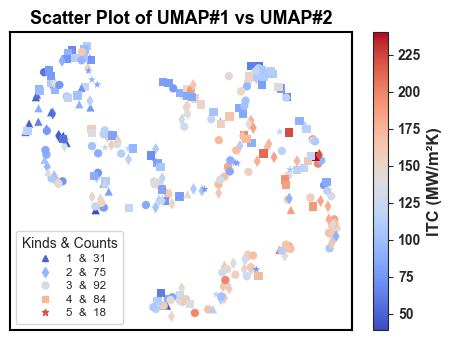

In [8]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(4.7, 3.5))
sns.set_style('ticks')

marker_sizes = {
    1: 80,  # 圆形
    2: 80,  # 方形
    3: 100, # 三角形
    4: 80,  # 菱形
    5: 200  # 星形（增大大小）
}

# 创建一个对应每个数据点的大小列表
sizes = [marker_sizes[kind] for kind in df['kinds']]

scatter = sns.scatterplot(
    data=df,
    x='UMAP1', 
    y='UMAP2', 
    hue='TC_mean', 
    palette='coolwarm',
    style='kinds',
    markers={1: '^', 2: 'd', 3: 'o', 4: 's', 5: '*'},
    sizes=sizes,
    legend=False,
    edgecolor='white',
    linewidth=0.01
)

# 添加颜色条
norm = plt.Normalize(df['TC_mean'].min(), df['TC_mean'].max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])  # 需要设置一个空数组以避免警告
cbar = plt.colorbar(sm, ax=scatter, label='TC_mean')

# 加粗颜色条的标签
tick_labels = [str('{:.0f}'.format(tick)) for tick in cbar.get_ticks()]
cbar.set_ticklabels(tick_labels)
cbar.ax.set_yticklabels(tick_labels, fontsize=10, fontweight='bold')
cbar.set_label('ITC (MW/m²K)', fontsize=12, fontweight='bold') 

plt.title('Scatter Plot of UMAP1 vs UMAP2')
# plt.xlabel('UMAP#1')
# plt.ylabel('UMAP#2')

axes.spines['bottom'].set_linewidth(1.5)
axes.spines['left'].set_linewidth(1.5)
axes.spines['top'].set_linewidth(1.5)
axes.spines['right'].set_linewidth(1.5)

# 隐藏坐标轴的刻度和标签
axes.tick_params(left=False, bottom=False)
axes.set_xticklabels([])
axes.set_yticklabels([])

plt.title(
    'Scatter Plot of UMAP#1 vs UMAP#2',
    fontsize=13,
    fontweight='bold'
)

plt.xlabel(
    '',
#     fontsize=13,
#     fontweight='bold'
)

plt.ylabel(
    '', 
#     fontsize=13,
#     fontweight='bold'
)

plt.xticks(
#     [0.900, 0.905, 0.910, 0.915],
#     rotation=90,
    fontsize=14,
    fontweight='bold')

plt.yticks(
#     [0.900, 0.905, 0.910, 0.915],
#     rotation=90,
    fontsize=14,
    fontweight='bold')

# 自定义图例
legend_labels = {1: '1  &  31', 2: '2  &  75', 3: '3  &  92', 4: '4  &  84', 5: '5  &  18'}
legend_markers = {1: '^', 2: 'd', 3: 'o', 4: 's', 5: '*'}
legend_color = {1: '#4963D2', 2: '#94B6FE', 3: '#D3DBE6', 4: '#F8B79B', 5: '#D55343'}

# 创建图例项
legend_handles = []
for kind, label in legend_labels.items():
    marker_color = legend_color[kind]  # 可以根据需要设置颜色
    marker_size = 5  # 设置标记的大小
    marker_edge_color = 'white',
    marker = plt.Line2D([], [], marker=legend_markers[kind], linestyle='None', 
                         markersize=marker_size, color=marker_color, label=label,)
    legend_handles.append(marker)

# 添加图例到图中，并调整大小
plt.legend(
    handles=legend_handles,
    title='Kinds & Counts',
#     bbox_to_anchor=(1.05, 1),
    loc='lower left',
    fontsize='small',
    borderpad=0.5,
    labelspacing=0.3
)  # 设置标签之间的间距

# # 显示图例
# plt.legend(title='Kinds', bbox_to_anchor=(1.05, 1), loc='upper left')  # 调整图例位置
plt.tight_layout()  # 自动调整布局以防止重叠
plt.savefig('1umap.jpg',dpi=800)